In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools
from pathlib import Path
import pickle

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#this works for alex only
df = pd.read_csv("drive/MyDrive/imdb_dataset_processed_new.csv")
df

,processed,label
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49577,think movie right good job creative original e...,1
49578,bad plot bad dialogue bad acting idiotic direc...,0
49579,catholic teach parochial elementary school nun...,0
49580,go disagree previous comment maltin second rat...,0


In [ ]:
#for non-alex users:
df = pd.read_csv("imdb_dataset_processed_new.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: 'imdb_dataset_processed_new.csv'

In [ ]:
tokenizer = get_tokenizer('basic_english')
tokenized_data = [tokenizer(text) for text in df['processed']]

vocab = build_vocab_from_iterator(tokenized_data, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
len(vocab)

89427

In [ ]:
# Convert tokenized data to numerical data
numericalized_data = [torch.tensor(vocab(tokenized_line), dtype=torch.long) for tokenized_line in tokenized_data]

In [ ]:
review_lengths = [len(review) for review in numericalized_data]
lengths_df = pd.DataFrame(review_lengths, columns=['x'])
lengths_df

,x
0,139
1,76
2,72
3,58
4,110
...,...
49577,61
49578,53
49579,97
49580,98


<Axes: title={'center': 'Word Count Distribution in All Reviews'}, xlabel='Review Word Count', ylabel='Frequency'>

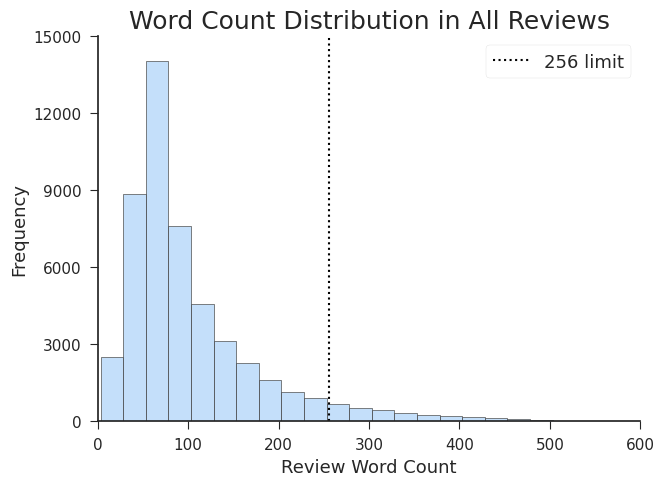

In [ ]:
sns.set_theme(style="ticks")
sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-paper')

binwidth = 25


min = np.min(review_lengths)
max = np.max(review_lengths)


f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
plt.title('Word Count Distribution in All Reviews', fontsize=18)
plt.xlabel('Review Word Count', fontsize=13)
plt.xticks(np.arange(0, 700, 100), fontsize=11)
plt.xlim(0, 600)
plt.ylabel('Frequency', fontsize=13)
plt.yticks(np.arange(0, 16000, 3000), fontsize=11)
plt.ylim(0, 15000)
plt.axvline(x=256, color='black', linestyle='dotted', linewidth=1.5, label='256 limit')
plt.legend(prop={'size': 13})
sns.histplot(
    lengths_df,
    x="x",
    alpha=0.5,
    color='#8BC1F7',
    edgecolor=".3",
    linewidth=.5,
    bins=range(min, max + binwidth, binwidth))


In [ ]:
min, max

(3, 1268)

In [ ]:
np.mean(review_lengths), np.median(review_lengths)

(102.81507401879715, 76.0)

In [ ]:
np.sum([item < 256 for item in review_lengths]) / len(review_lengths)

0.9420959219071438

In [ ]:
padded_sequences = pad_sequence(numericalized_data, batch_first=True)

In [ ]:
padded_sequences[0].shape

torch.Size([1268])

In [ ]:
numericalized_data[0].shape

torch.Size([139])

In [ ]:
def pad_and_truncate(tensor, max_length=256):
    padded_tensor = []

    for row in tensor:
        if len(row) < max_length:
            # Pad with zeros
            padded_row = torch.cat([row, torch.zeros(max_length - len(row), dtype=row.dtype)])
        else:
            # Truncate
            padded_row = row[:max_length]

        padded_tensor.append(padded_row)

    return torch.stack(padded_tensor)

padded_trimmed = pad_and_truncate(numericalized_data)

In [ ]:
padded_sequences = padded_trimmed
labels = torch.tensor(df['label'].values, dtype=torch.float)

In [ ]:
padded_sequences.shape

torch.Size([49582, 256])

In [ ]:
labels.shape

torch.Size([49582])

In [ ]:
test_size = 0.2
val_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=test_size, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=1)

In [ ]:
len(X_train), len(X_val), len(X_test)

(31732, 7933, 9917)

In [ ]:
X_train[0]

tensor([ 5658,   736,    38,  6190,  3280,   109,   142,  1303,    30,  6016,
            6,   524,  4362,  6237,    97,   946,  7338,  6311,  1106, 52060,
            8,    45,     8,    99,  2317,   995,   110,     2,   805,   836,
           51,     3,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout, embedding_matrix):
        super().__init__()
        # freeze=False if you want the embedding weights to be changed by the optimizer
        # Comment the first line and comment out the second line if you want to learn the whole embedding from scratch
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=0, freeze=False)
        #self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

In [ ]:
vocab_size = len(vocab)
output_dim = 1
clip_norm = 2
patience = 4
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_lstm(config):
    # If model is already saved, do not retrain on same config
    # This allows you to stop and resume training, assuming you have the previous models saved
    # Returns none state dict, infinite loss and empty history but that should have been saved before if it was best!!!
    try_saved_model = Path('./lstm_classifier_' + str(config)+'.pt')
    if try_saved_model.is_file():
      return None, {}

    embedding_size = config["embedding_size"]
    window = config["window"]
    hidden_dim = config["hidden_dim"]
    num_layers = config["num_layers"]
    dropout = config["dropout"]
    lr = config["lr"]

    w2v = Word2Vec(sentences=tokenized_data, vector_size=embedding_size, window=window, min_count=1, workers=4)
    embedding_matrix = torch.zeros(len(vocab), embedding_size)
    for i, token in enumerate(vocab.get_itos()):
        if token in w2v.wv:
            embedding_matrix[i] = torch.tensor(w2v.wv[token])
        else:
            print('here')
            exit()
            embedding_matrix[i] = torch.zeros(embedding_size)


    history = {
      'train_loss': [],
      'train_accuracy': [],
      'validation_loss': [],
      'validation_accuracy': []
    }

    train_set = TensorDataset(X_train, y_train)
    valid_set = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

    model = LSTMClassifier(vocab_size, output_dim, hidden_dim, embedding_size, num_layers, dropout, embedding_matrix)
    model.to(device)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_validation_loss = torch.inf
    early_stop_triggers = 0
    epoch = 0

    while early_stop_triggers < patience:
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.type(torch.float).unsqueeze(1)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluation on training data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.unsqueeze(1)
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        history['train_accuracy'].append(train_accuracy)

        # Evaluation on validation data
        validation_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.unsqueeze(1)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                validation_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = correct / total
        validation_loss /= len(val_loader)
        history['validation_loss'].append(validation_loss)
        history['validation_accuracy'].append(validation_accuracy)
        if validation_loss < best_validation_loss:
            early_stop_triggers = 0
            best_validation_loss = validation_loss
            print(f"[Update] Validation loss: {best_validation_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}%")
            torch.save(model.state_dict(), './lstm_classifier_'+str(config)+'.pt')
        else:
            early_stop_triggers += 1

        epoch += 1
    return model.state_dict(), history

In [ ]:
# This is the training + hyperparameter tuning loop
# Not supposed to be re-run
# Skip otherwise takes 3+ hours, files are loaded below

# This config can be split into a model and embedding config to avoid excessive recomputation of the embedding matrix
# But we didn't do that as we got GPU power :)
config = {
   "embedding_size": [200, 250, 300],
   "window": [5, 10],
   "hidden_dim": [32, 64, 128],
   "num_layers": [2, 3],
   "dropout": [0.3, 0.4, 0.5],
   "lr": [0.001, 0.0005, 0.0001]
}

hyperparameters = config.keys()
combinations = list(itertools.product(*(config[key] for key in hyperparameters)))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#best_validation_loss = torch.inf
best_validation_accuracy = 0
best_config = []
best_history = {}
best_params = None

for i, combination in enumerate(combinations):
    current_config = dict(zip(hyperparameters, combination))
    print(f"Model [{i+1}/{len(combinations)}] with config: {current_config}")
    params, history = train_lstm(current_config)
    training_epochs = len(history["validation_accuracy"])
    #validation_loss = history["validation_loss"][training_epochs - patience - 1]
    #Get the accuracy metric for the saved model
    validation_accuracy = history["validation_accuracy"][training_epochs - patience - 1]
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      best_config = current_config
      best_history = history
      best_params = params

Model [1/324] with config: {'embedding_size': 200, 'window': 5, 'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001}


KeyboardInterrupt: 

In [ ]:
# You should download those
with open('best_history.pkl', 'wb') as f:
  pickle.dump(best_history, f)
with open('best_config.pkl', 'wb') as f:
  pickle.dump(best_config, f)

torch.save(best_params, 'best_model.pt')

In [ ]:
# Best config
#{'embedding_size': 250, 'window': 5, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.3, 'lr': 0.001}

{'embedding_size': 250, 'window': 5, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.3, 'lr': 0.001}


In [ ]:
with open('best_history.pkl', 'rb') as f:
    best_history = pickle.load(f)
with open('best_config.pkl', 'rb') as f:
    best_config = pickle.load(f)

print(best_config)

hidden_dim = best_config['hidden_dim']
hidden_dim = best_config["hidden_dim"]
num_layers = best_config["num_layers"]
dropout = best_config["dropout"]
lr = best_config["lr"]
embedding_size = best_config["embedding_size"]
# Does not need defining as it's the embedding layer which is saved
embedding_matrix = torch.zeros(len(vocab), embedding_size)

model = LSTMClassifier(vocab_size, output_dim, hidden_dim, embedding_size, num_layers, dropout, embedding_matrix)

# Non Alex
# model_path = 'best_model.pt'
# Alex
model_path = 'drive/MyDrive/best_model.pt'

# Should be on GPU, otherwise can't load
model.load_state_dict(torch.load(model_path))
model.to(device)

{'embedding_size': 250, 'window': 5, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.3, 'lr': 0.001}


LSTMClassifier(
  (embedding): Embedding(89427, 250, padding_idx=0)
  (lstm): LSTM(250, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
print([str(round(item, 3)) for item in best_history['train_loss']])
print([str(round(item, 3)) for item in best_history['validation_loss']])
print([str(round(item, 3)) for item in best_history['train_accuracy']])
print([str(round(item, 3)) for item in best_history['validation_accuracy']])

['0.685', '0.693', '0.691', '0.662', '0.568', '0.404', '0.318', '0.272', '0.201', '0.159', '0.123', '0.096']
['0.69', '0.691', '0.687', '0.655', '0.431', '0.357', '0.312', '0.297', '0.315', '0.331', '0.344', '0.412']
['0.51', '0.507', '0.497', '0.651', '0.84', '0.87', '0.905', '0.925', '0.943', '0.958', '0.971', '0.976']
['0.514', '0.511', '0.493', '0.65', '0.835', '0.853', '0.877', '0.884', '0.883', '0.883', '0.884', '0.875']


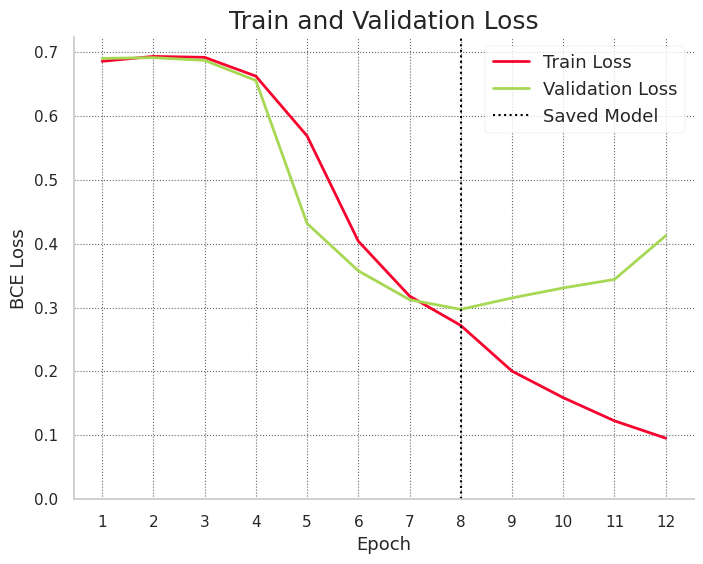

In [ ]:
epochs = len(best_history['train_loss'])
sns.set_theme(style="ticks")
sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-paper')
sns.set_style("whitegrid", {"grid.color": ".4", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
sns.lineplot(x=range(epochs), y=best_history['train_loss'], label='Train Loss', color='#f7022e', linewidth=2)
sns.lineplot(x=range(epochs), y=best_history['validation_loss'], label='Validation Loss', color='#a6d854', linewidth=2)
sns.despine()
plt.axvline(x=epochs - patience - 1, color='black', linestyle='dotted', linewidth=1.5, label='Saved Model')
plt.title('Train and Validation Loss',fontsize=18)
plt.xlabel('Epoch', fontsize=13)
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1), fontsize=11)
plt.ylabel('BCE Loss', fontsize=13)
plt.yticks(np.arange(0, 0.75, 0.1), fontsize=11)
plt.legend(prop={'size': 13})
plt.show()

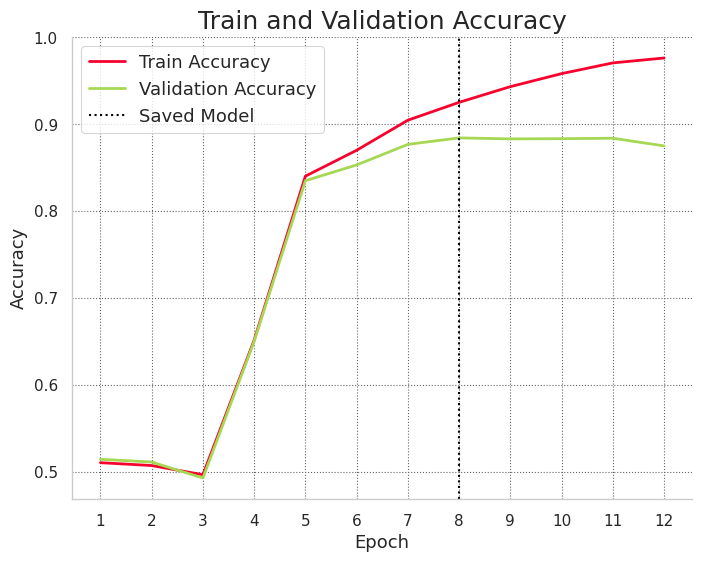

In [ ]:
plt.figure(figsize=(8,6))
sns.set_context("paper")
sns.set_style("whitegrid", {"grid.color": ".4", "grid.linestyle": ":"})
sns.lineplot(x=range(epochs), y=best_history['train_accuracy'], label='Train Accuracy', color='#f7022e', linewidth=2)
sns.despine()
sns.lineplot(x=range(epochs), y=best_history['validation_accuracy'], label='Validation Accuracy', color='#a6d854', linewidth=2)
plt.axvline(x=epochs - patience - 1, color='black', linestyle='dotted', linewidth=1.5, label='Saved Model')
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1), fontsize=11)
plt.title('Train and Validation Accuracy', fontsize=18)
plt.yticks(np.arange(0.5, 1.05, 0.1), fontsize=11)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.legend(prop={'size': 13})

plt.show()

In [ ]:
test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

model.eval()
all_predictions = []
with torch.inference_mode():
  for inputs, labels in test_loader: #batch is needed as cuda runs out of memory if all x_test are passed
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.unsqueeze(1)
    outputs = model(inputs)
    predicted = (outputs > 0.5).float()
    all_predictions.append(predicted.cpu().numpy())

all_predictions = [prediction for batch in all_predictions for prediction in batch]

In [ ]:
print(classification_report(all_predictions, y_test.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      4547
         1.0       0.92      0.84      0.88      5370

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.88      0.87      0.87      9917



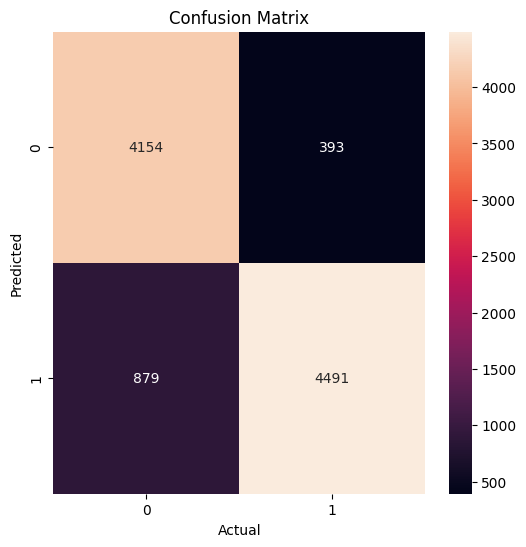

In [ ]:
c_matrix = confusion_matrix(all_predictions, y_test.cpu().numpy())
plt.figure(figsize=(6,6))
sns.color_palette("colorblind")
sns.heatmap(c_matrix, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()